# Wi-Fi Network Security Threat Detection Using Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.utils import rdpcap
from scapy.layers.inet import IP
import joblib
import warnings
from datetime import datetime
import os
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, precision_recall_curve,
                           average_precision_score, confusion_matrix,
                           roc_curve, auc, silhouette_score)
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../datasets/synthetic_wifi.csv')
# df = pd.read_csv('../datasets/wifi/output_1201_new.csv')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def create_traffic_overview(df, figsize=(20,12)):
    """
    Creates overview dashboard focused on TCP/IP traffic patterns
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig)
    
    # Time series analysis of packet lengths
    ax1 = fig.add_subplot(gs[0, :])
    df.groupby('frame.time_epoch')['frame.len'].mean().plot(ax=ax1)
    ax1.set_title('Average Packet Length Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Packet Length')
    
    # TCP vs UDP distribution
    ax2 = fig.add_subplot(gs[1, 0])
    protocol_counts = {
        'TCP': df['tcp.len'].notna().sum(),
        'UDP': df['udp.length'].notna().sum()
    }
    pd.Series(protocol_counts).plot(kind='bar', ax=ax2)
    ax2.set_title('Protocol Distribution')
    ax2.set_ylabel('Number of Packets')
    
    # Source IP distribution
    ax3 = fig.add_subplot(gs[1, 1])
    top_ips = df['ip.src'].value_counts().head(10)
    top_ips.plot(kind='bar', ax=ax3)
    ax3.set_title('Top Source IPs')
    ax3.set_xlabel('Source IP')
    ax3.set_ylabel('Packet Count')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # TCP Flags analysis
    ax4 = fig.add_subplot(gs[2, 0])
    if df['tcp.flags'].notna().any():
        flag_dist = df['tcp.flags'].value_counts()
        flag_dist.plot(kind='bar', ax=ax4)
        ax4.set_title('TCP Flags Distribution')
        ax4.set_xlabel('Flags')
        ax4.set_ylabel('Count')
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    # Packet length distribution
    ax5 = fig.add_subplot(gs[2, 1])
    sns.histplot(data=df, x='frame.len', bins=50, ax=ax5)
    ax5.set_title('Packet Length Distribution')
    ax5.set_xlabel('Length (bytes)')
    
    plt.tight_layout()
    return fig

def create_attack_analysis(df, figsize=(15,15)):
    """
    Creates visualizations specifically designed to detect attack patterns in TCP/IP traffic
    """
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig)
    
    # Port scanning detection
    ax1 = fig.add_subplot(gs[0, :])
    time_windows = pd.qcut(df['frame.time_epoch'], q=20, duplicates='drop')
    port_activity = df.groupby(time_windows)['tcp.dstport'].nunique()
    port_activity.plot(ax=ax1)
    ax1.set_title('Unique Destination Ports Over Time (Port Scanning)')
    ax1.set_xlabel('Time Window')
    ax1.set_ylabel('Number of Unique Ports')
    
    # DoS detection through packet frequency
    ax2 = fig.add_subplot(gs[1, 0])
    ip_packet_counts = df.groupby('ip.src')['frame.len'].count()
    ip_packet_rates = ip_packet_counts / (df['frame.time_epoch'].max() - df['frame.time_epoch'].min())
    ip_packet_rates.sort_values(ascending=False).head(10).plot(kind='bar', ax=ax2)
    ax2.set_title('Top Source IPs by Packet Rate (DoS Detection)')
    ax2.set_xlabel('Source IP')
    ax2.set_ylabel('Packets per Second')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Connection analysis
    ax3 = fig.add_subplot(gs[1, 1])
    df['connection'] = df['ip.src'] + ':' + df['tcp.srcport'].astype(str) + ' -> ' + \
                      df['ip.dst'] + ':' + df['tcp.dstport'].astype(str)
    top_connections = df['connection'].value_counts().head(10)
    top_connections.plot(kind='bar', ax=ax3)
    ax3.set_title('Most Active TCP Connections')
    ax3.set_xlabel('Connection')
    ax3.set_ylabel('Packet Count')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # TCP Sequence number analysis
    ax4 = fig.add_subplot(gs[2, 0])
    sns.scatterplot(data=df.sample(min(1000, len(df))), 
                   x='frame.time_epoch', y='tcp.seq', 
                   alpha=0.5, ax=ax4)
    ax4.set_title('TCP Sequence Numbers Over Time')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Sequence Number')
    
    # Packet length patterns
    ax5 = fig.add_subplot(gs[2, 1])
    sns.boxplot(data=df, x='tcp.flags', y='frame.len', ax=ax5)
    ax5.set_title('Packet Lengths by TCP Flags')
    ax5.set_xlabel('TCP Flags')
    ax5.set_ylabel('Packet Length')
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    return fig

def analyze_network_traffic(df):
    """
    Main analysis function that creates comprehensive traffic visualizations
    """
    # Create the overview and attack analysis visualizations
    traffic_fig = create_traffic_overview(df)
    attack_fig = create_attack_analysis(df)
    
    return traffic_fig, attack_fig

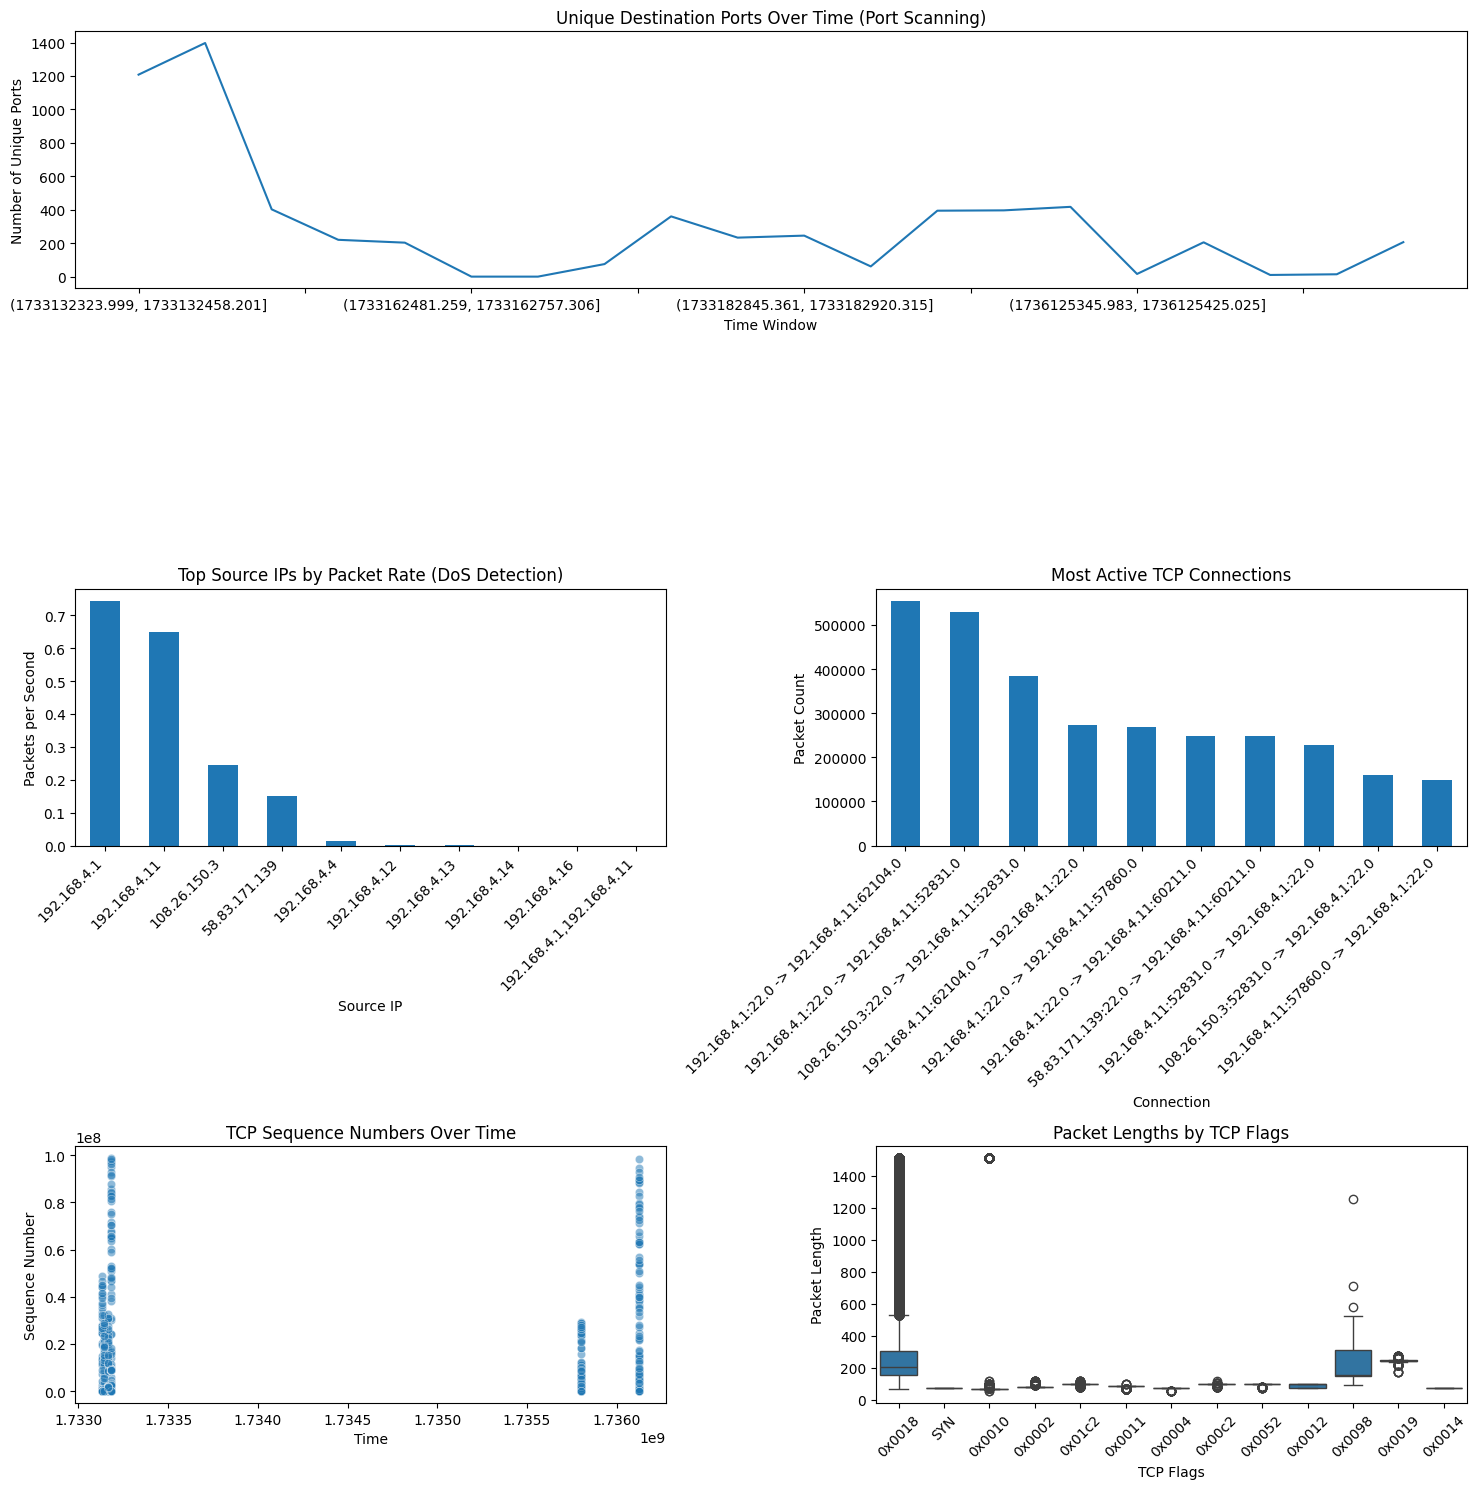

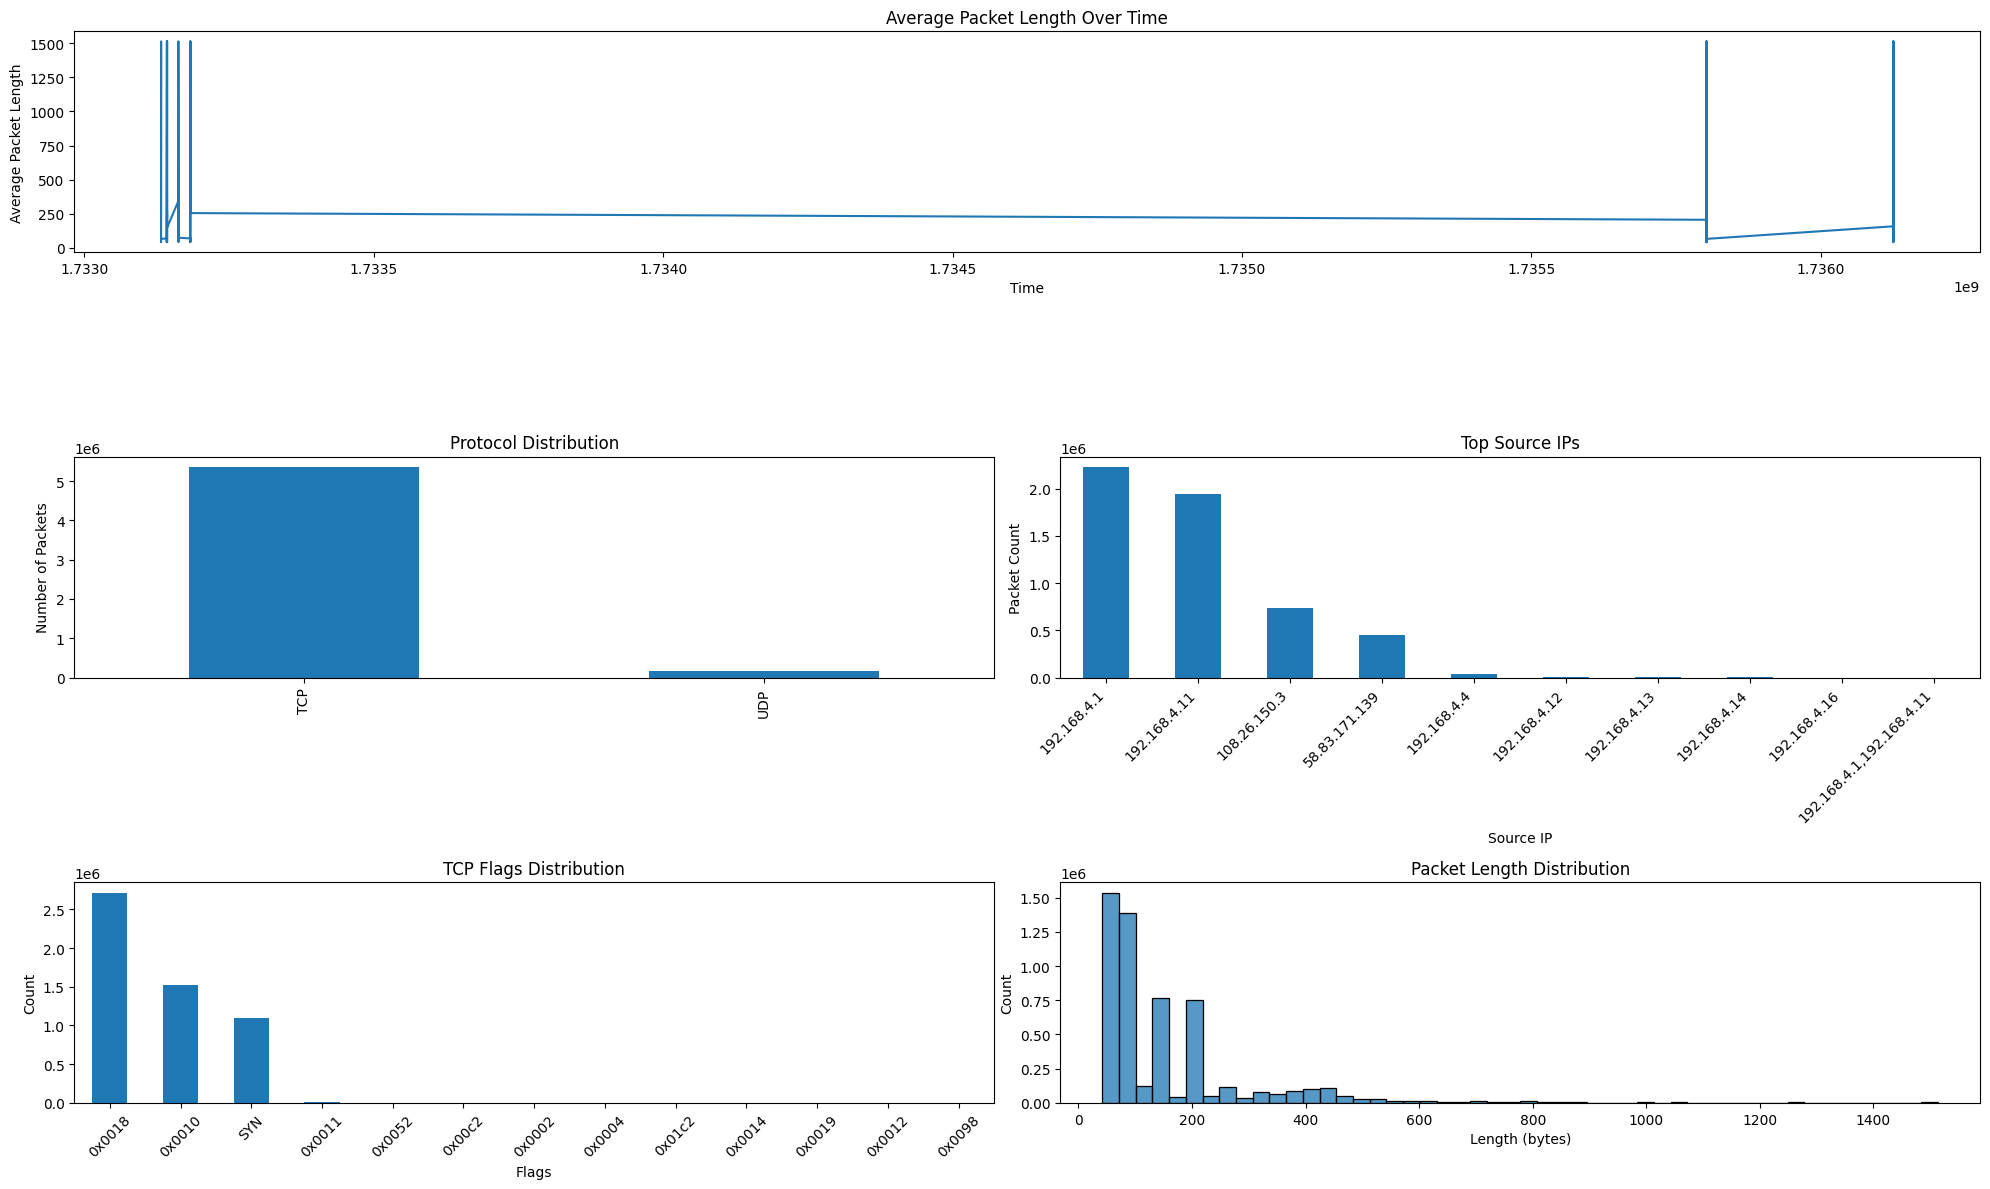

<Figure size 640x480 with 0 Axes>

In [7]:
# Generate visualizations
traffic_fig, attack_fig = analyze_network_traffic(df)

# Display the figures
plt.figure(traffic_fig.number)
plt.show()

plt.figure(attack_fig.number)
plt.show()

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def debug_attack_detection_plots(df, figsize=(15,15)):
    """
    Debug version of attack detection plots with data validation
    """
    # Print column names for debugging
    print("Available columns:", df.columns.tolist())
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig)
    
    try:
        # Port scanning analysis
        ax1 = fig.add_subplot(gs[0, 0])
        port_scan_data = df['tcp.srcport'].value_counts()
        if not port_scan_data.empty:
            port_scan_data[:20].plot(kind='bar', ax=ax1)
            ax1.set_title('Top Source Ports (Port Scan Detection)')
            ax1.set_xlabel('Source Port')
            ax1.set_ylabel('Count')
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        else:
            print("No TCP source port data available")
            
        # DoS detection
        ax2 = fig.add_subplot(gs[0, 1])
        if 'ip.src' in df.columns:
            dos_data = df['ip.src'].value_counts()[:20]
            if not dos_data.empty:
                dos_data.plot(kind='bar', ax=ax2)
                ax2.set_title('Top Source IPs (DoS Detection)')
                ax2.set_xlabel('Source IP')
                ax2.set_ylabel('Count')
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        else:
            print("No IP source data available")
            
        # TCP Flags analysis
        ax3 = fig.add_subplot(gs[1, 0])
        if 'tcp.flags' in df.columns:
            flag_counts = df['tcp.flags'].value_counts()
            if not flag_counts.empty:
                flag_counts.plot(kind='bar', ax=ax3)
                ax3.set_title('TCP Flags Distribution')
                ax3.set_xlabel('TCP Flags')
                ax3.set_ylabel('Count')
        else:
            print("No TCP flags data available")
            
        # Packet length analysis
        ax4 = fig.add_subplot(gs[1, 1])
        if 'frame.len' in df.columns:
            if df['frame.len'].notna().any():
                sns.histplot(data=df, x='frame.len', bins=50, ax=ax4)
                ax4.set_title('Packet Length Distribution')
                ax4.set_xlabel('Length')
        else:
            print("No frame length data available")
        
        plt.tight_layout()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        
    return fig

def debug_stats_analysis(df, figsize=(15,10)):
    """
    Debug version of statistical analysis with data validation
    """
    # Print data info for debugging
    print("\nDataframe info:")
    print(df.info())
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig)
    
    try:
        # Numeric correlation analysis
        ax1 = fig.add_subplot(gs[0, :])
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print("\nNumeric columns:", numeric_cols.tolist())
        
        if len(numeric_cols) > 0:
            correlation_matrix = df[numeric_cols].corr()
            sns.heatmap(correlation_matrix, ax=ax1, cmap='coolwarm', center=0)
            ax1.set_title('Feature Correlation Matrix')
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        else:
            print("No numeric columns available for correlation analysis")
            
        # Length distributions
        ax2 = fig.add_subplot(gs[1, 0])
        if 'frame.len' in df.columns:
            if df['frame.len'].notna().any():
                sns.histplot(data=df, x='frame.len', bins=50, ax=ax2)
                ax2.set_title('Frame Length Distribution')
                ax2.set_xlabel('Length')
        else:
            print("No frame length data available")
            
        # Signal strength analysis
        ax3 = fig.add_subplot(gs[1, 1])
        if 'radiotap.dbm_antsignal' in df.columns:
            if df['radiotap.dbm_antsignal'].notna().any():
                sns.histplot(data=df, x='radiotap.dbm_antsignal', bins=50, ax=ax3)
                ax3.set_title('Signal Strength Distribution')
                ax3.set_xlabel('Signal Strength (dBm)')
        else:
            print("No signal strength data available")
            
        plt.tight_layout()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        
    return fig

def analyze_network_traffic_debug(df):
    """
    Debug version of main analysis function
    """
    print("Starting analysis with dataframe shape:", df.shape)
    
    attack_fig = debug_attack_detection_plots(df)
    stats_fig = debug_stats_analysis(df)
    
    return attack_fig, stats_fig

Starting analysis with dataframe shape: (10551408, 25)
Available columns: ['frame.time_epoch', 'frame.len', 'frame.protocols', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.sa', 'wlan.da', 'wlan.bssid', 'radiotap.channel.freq', 'radiotap.dbm_antsignal', 'radiotap.datarate', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport', 'tcp.flags', 'tcp.len', 'udp.length', 'tcp.stream', 'tcp.seq', 'tcp.ack', '_ws.col.protocol', 'connection']

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10551408 entries, 0 to 10551407
Data columns (total 25 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   frame.time_epoch        float64
 1   frame.len               int64  
 2   frame.protocols         object 
 3   wlan.fc.type            float64
 4   wlan.fc.subtype         float64
 5   wlan.sa                 object 
 6   wlan.da                 object 
 7   wlan.bssid              object 
 8   radiotap.channel.freq   float64
 9 

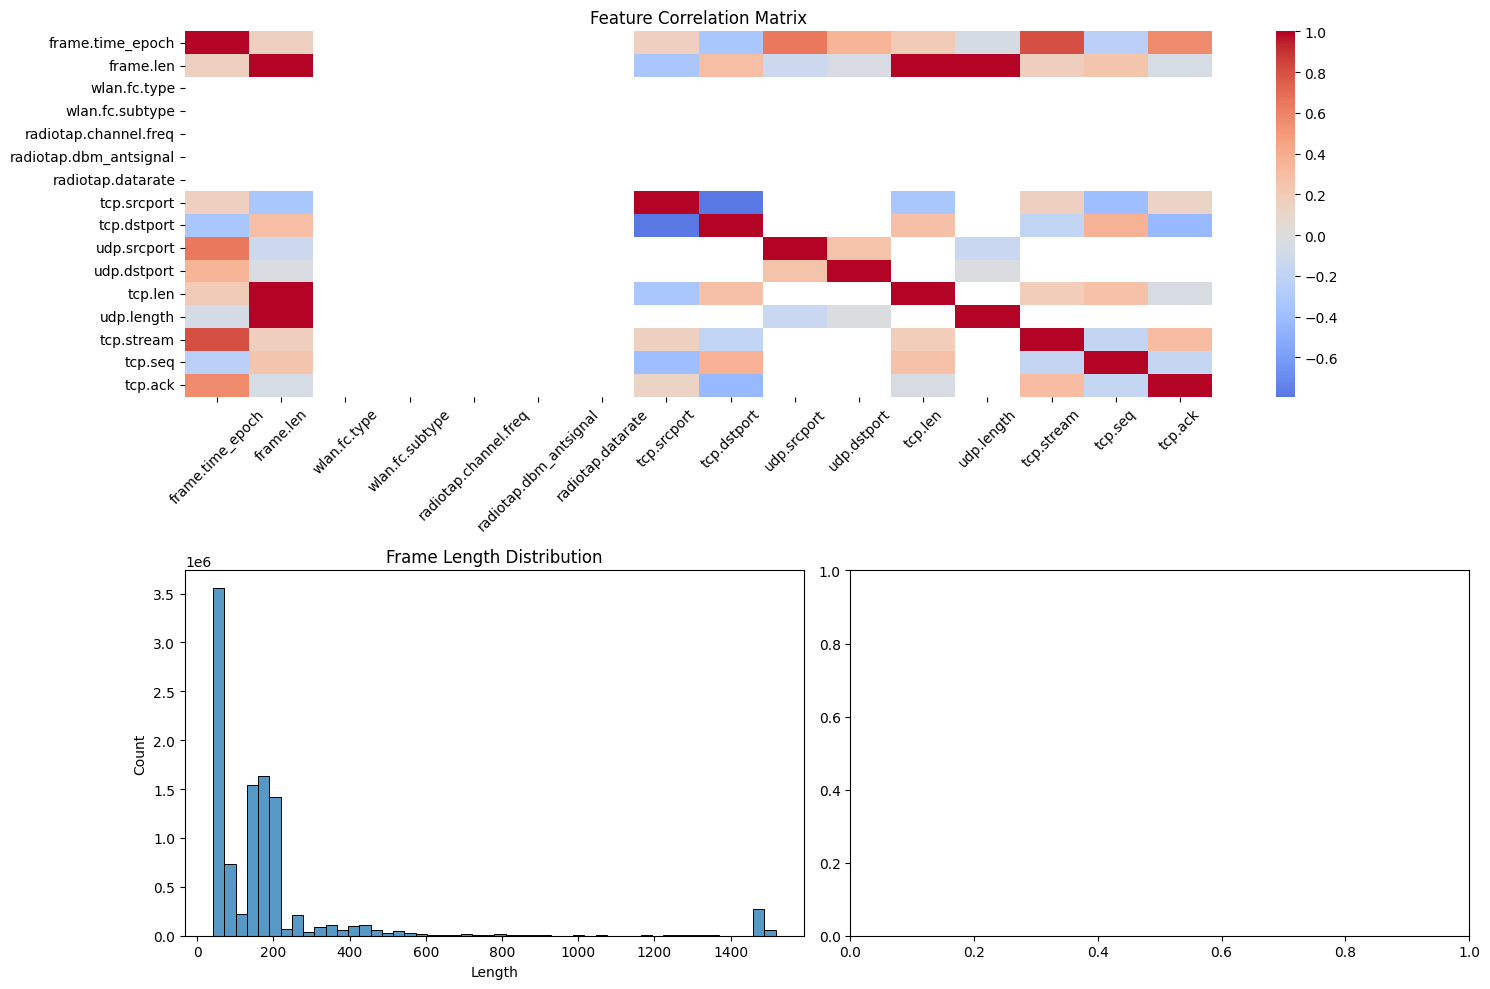

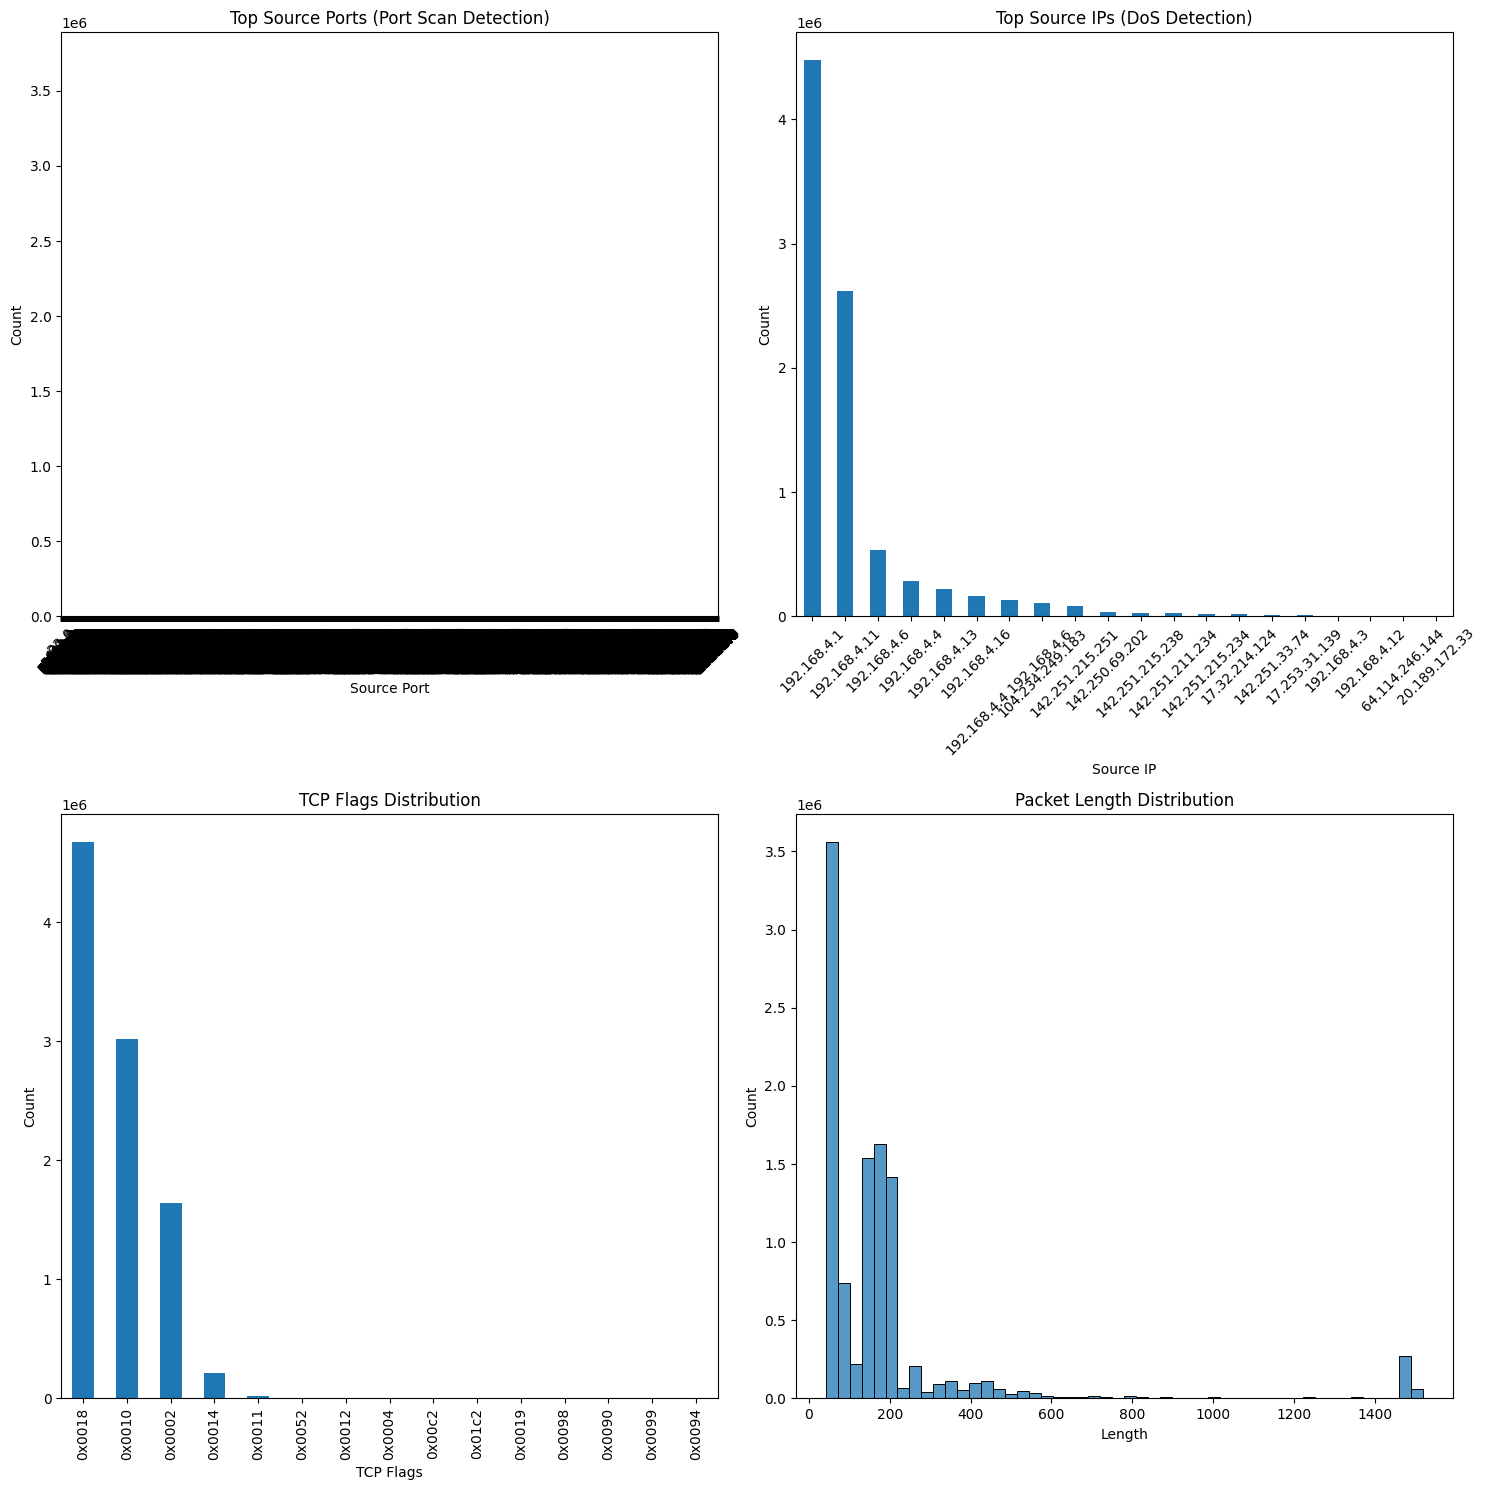

<Figure size 640x480 with 0 Axes>

In [13]:
# Run the debug version
attack_fig, stats_fig = analyze_network_traffic_debug(df)

# Try to display the figures
plt.figure(attack_fig.number)
plt.show()

plt.figure(stats_fig.number)
plt.show()